In [14]:
import os
import re
import requests
import time
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from IPython.core.display import display, HTML

%matplotlib inline

In [17]:
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

PROJECT_DB_PATH = config['DATABASES']['PROJECT_DB_PATH']

In [179]:
# create object to query database
engine = create_engine(PROJECT_DB_PATH)

df = pd.read_sql('SELECT * FROM Sections', engine)
df['section_name_len'] = df['section_name'].apply(len)
df = df[(df.section_name_len > 1) & (df.section_name_len < 25)]
df.reset_index(inplace=True)
df.head()

,index,section_id,filename,section_name,section_text,criteria,section_length,section_name_len
0,0,1,southwest-airlines-co_annual_report_1994.docx,FIRST SECTION,© 1994 Southwest Airlines Co. This annual repo...,<function heading at 0x000001D4AA492EA0>,83,13
1,3,4,southwest-airlines-co_annual_report_1994.docx,TO OUR SHAREHOLDERS,"In 1994, Southwest Airlines produced a profit ...",<function heading at 0x000001D4AA492EA0>,4862,19
2,4,5,southwest-airlines-co_annual_report_1994.docx,LOW COST,Southwest has the lowest cost structure among ...,<function heading at 0x000001D4AA492EA0>,2393,8
3,8,9,southwest-airlines-co_annual_report_1994.docx,FLEET SIZE,Southwest was specifically built to meet the n...,<function heading at 0x000001D4AA492EA0>,1885,10
4,15,16,southwest-airlines-co_annual_report_1994.docx,RESULTS OF OPERATIONS,1994 COMPARED WITH 1993 The Company's consolid...,<function heading at 0x000001D4AA492EA0>,13806,21


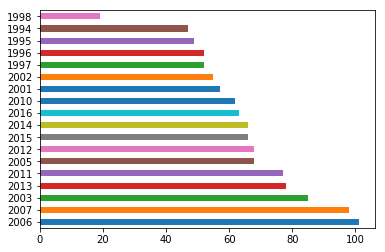

In [180]:
# extract the year
df['year'] = df['filename'].apply(lambda x: int(x.split('_')[-1].replace('.docx','')))

# plot the number of sections per year
df['year'].value_counts().plot.barh()

## SECTION CLUSTERING

In [181]:
# create two sets of text to cluster
# the section names and the combined section names and section text
text = df.section_name
all_text = df['section_name'] + ' ' + df['section_text']

# vectorize the text
vect = TfidfVectorizer(min_df=.01, max_df=.95, norm='l2',stop_words='english', max_features=5000, ngram_range=(1,2))
sections_names_vect = vect.fit_transform(text)

In [182]:
# cluster the document using KMeans

# step 1 - import the model
from sklearn.cluster import KMeans

# step 2 - instantiate the model
km = KMeans(n_clusters=20, random_state=42)

# step 3 - fit the model with data
# clustering is unsupervised so we do not have labels to add during .fit()
km.fit(sections_names_vect)

# step 4 - predict the cluster of each section_title
df['clusters'] = km.predict(sections_names_vect)

In [183]:
def review_clusters(df, n_clusters=20):
    for cl_num in range(n_clusters):
        print(cl_num)
        print(df['section_name'][df.clusters == cl_num].values[0:10])
        print()

review_clusters(df, n_clusters=20)

0
['ANNUAL MEETING' 'ANNUAL MEETING' 'ANNUAL MEETING' 'ANNUAL MEETING'
 'ANNUAL MEETING' 'ANNUAL MEETING' 'ANNUAL MEETING' 'ANNUAL MEETING'
 'WEB SITES ANNUAL MEETING' 'WEB SITES ANNUAL MEETING']

1
['TO OUR SHAREHOLDERS' 'LOW COST' 'FLEET SIZE' 'RESULTS OF OPERATIONS'
 'ACQUISITION' 'ACCOUNTING CHANGES' 'COMMITMENTS' 'COMMON STOCK'
 'ERNST & YOUNG LLP' 'AUDITORS']

2
['GARY A. BARRON*' 'GARY C. KELLY*' 'GARY A. BARRON*' 'GARY C. KELLY*'
 'GARY A. BARRON*' 'GARY C. KELLY*' 'GARY A. BARRON*' 'GARY C. KELLY*'
 'GARY C. KELLY*' 'GARY C. KELLY*']

3
['REGULATION' 'REGULATION' 'REGULATION' 'REGULATION' 'SECURITY REGULATION'
 'ENVIRONMENTAL REGULATION' 'REGULATION' 'SECURITY REGULATION'
 'ENVIRONMENTAL REGULATION' 'INTERNATIONAL REGULATION']

4
['WILLIAM P. HOBBY, JR.' 'WILLIAM Q. MILLER' 'WILLIAM D. LYONS'
 'WILLIAM P. HOBBY, JR.' 'WILLIAM D. LYONS' 'WILLIAM Q. MILLER'
 'WILLIAM P. HOBBY, JR.' 'WILLIAM D. LYONS' 'WILLIAM Q. MILLER'
 'WILLIAM P. HOBBY']

5
['LEASES' 'LEASES' 'LEASES' 'LEASES

In [184]:
# vectorize the combined section names and text
vect = TfidfVectorizer(min_df=.01, max_df=.95, norm='l2',stop_words='english', max_features=5000, ngram_range=(1,2))
sections_names_vect = vect.fit_transform(all_text)

# cluster the combined section names and text
km = KMeans(n_clusters=20, random_state=42)
df['clusters'] = km.fit_predict(sections_names_vect)
review_clusters(df, n_clusters=20)

0
['HERBERT D. KELLEHER' 'JUNE M. MORRIS' 'GARY A. BARRON*' 'GARY C. KELLY*'
 'HERBERT D. KELLEHER' 'JUNE M. MORRIS' 'GARY A. BARRON*' 'GARY C. KELLY*'
 'HERBERT D. KELLEHER' 'JUNE M. MORRIS']

1
['EMPLOYEES' 'EMPLOYEES' 'EMPLOYEES' 'EMPLOYEES' 'EMPLOYEES' 'EMPLOYEES'
 'EMPLOYEES' 'EMPLOYEES' 'EMPLOYEES' 'EMPLOYEES']

2
['COLLEEN C. BARRETT*' 'JOHN G. DENISON*' 'CAROLYN R. BATES'
 'ALAN S. DAVIS' 'CAMILLE T. KEITH' 'PETE MCGLADE' 'WILLIAM Q. MILLER'
 'JAMES F. PARKER*' 'ROBERT W. RAPP, JR.' 'RON RICKS*']

3
['PART III' 'PART IV' 'W. KING' 'A-52' 'A-53' 'A-54' 'A-55' 'A-56'
 'SECTION 16(A) COMPLIANCE' 'CORPORATE  GOVERNANCE']

4
['COMMITMENTS' 'COMMITMENTS' 'OTHER' 'COMMITMENTS' 'ACCRUED LIABILITIES'
 'MARKET RISK' 'COMMITMENTS' '(IN THOUSANDS)' 'MARKET RISK' 'COMMITMENTS']

5
['JOHN D. OWEN' 'DOUGLAS H. BROOKS' 'JOHN G. DENISON' 'NANCY B. LOEFFLER'
 'THOMAS M. NEALON' 'DANIEL D. VILLANUEVA' 'J. VERONICA BIGGINS'
 'DOUGLAS H. BROOKS' 'JOHN G. DENISON' 'NANCY B. LOEFFLER']

6
['ANNUAL ME

### Cluster with doc2vec embeddings

In [214]:
import gensim

# format section text for gensm Doc2Vec
def read_corpus(text, tokens_only=False):
    for ind, line in enumerate(all_text):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), ['doc{}'.format(ind)])

# store and review the structured sections
train_corpus = list(read_corpus(text, tokens_only=False))
train_corpus[0]

TaggedDocument(words=['first', 'section', 'southwest', 'airlines', 'co', 'this', 'annual', 'report', 'was', 'downloaded', 'from', 'our', 'website', 'at'], tags=['doc0'])

In [216]:
from gensim.models import doc2vec

model = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025)  # use fixed learning rate
model.build_vocab(train_corpus)

for epoch in range(100):
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

In [217]:
doc_vecs = []
for doc in train_corpus:
    inferred_vector = model.infer_vector(doc.words)
    doc_vecs.append(inferred_vector)

In [218]:
df_vecs = pd.DataFrame(doc_vecs)
df_vecs['section_name'] = df['section_name']
df_vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,section_name
0,0.000026,-0.000832,-0.000454,-0.001209,0.000714,-0.000906,-0.000741,-0.001200,0.001589,0.000564,...,0.000683,-0.000108,-0.001327,-0.000988,-0.000538,-0.000583,0.001214,-0.000798,-0.000401,FIRST SECTION
1,-0.464362,-0.589569,-0.297203,-0.297019,0.479326,-0.811833,-0.210304,1.246164,0.076794,0.493001,...,-0.146374,-0.116005,-0.250629,-0.589496,-1.332696,-0.729542,0.673928,0.597872,-0.220945,TO OUR SHAREHOLDERS
2,-0.028999,-0.366979,-0.176890,-0.041816,0.174716,-0.663228,-0.028220,1.002754,-0.420175,0.218939,...,0.389830,-0.033859,-0.204248,-0.275127,-0.891798,-0.094932,0.860216,0.060035,-0.038226,LOW COST
3,-0.007139,-0.182509,-0.212655,0.019192,0.374311,-0.507286,-0.048070,0.702364,-0.230614,0.198785,...,0.464082,0.212582,-0.180757,-0.647055,-0.887949,0.133952,0.447943,0.258888,-0.179182,FLEET SIZE
4,0.699377,-1.265107,0.896331,1.212229,0.032882,-0.291981,0.164654,2.087211,-1.511214,-0.381763,...,0.594055,-1.401285,-0.224916,-0.725514,-2.145437,0.453249,1.901824,0.007396,-1.956407,RESULTS OF OPERATIONS


In [222]:
km = KMeans(n_clusters=5, random_state=42)
df_vecs['clusters'] = km.fit_predict(df_vecs.drop('section_name', axis=1))
review_clusters(df_vecs, n_clusters=5)

0
['FLEET SIZE' 'ACQUISITION' 'ACCOUNTING CHANGES' 'LEASES' 'COMMON STOCK'
 'INCOME TAXES' 'TO OUR SHAREHOLDERS:' 'RESULTS OF OPERATIONS' 'LEASES'
 'COMMON STOCK']

1
['TO OUR SHAREHOLDERS' 'LOW COST' 'RESULTS OF OPERATIONS' 'STOCK PLANS'
 'LOOKING AHEAD.' 'COMMITMENTS' 'STOCK PLANS' 'OPERATING EXPENSES'
 'STOCK PLANS' 'RESULTS OF OPERATIONS']

2
['FIRST SECTION' 'COMMITMENTS' 'ERNST & YOUNG LLP' 'AUDITORS'
 'P. O. BOX 36611' 'ANNUAL MEETING' 'SEC FORM 10-K' 'GENE H. BISHOP'
 'C. WEBB CROCKETT' 'WILLIAM P. HOBBY, JR.']

3
['PART I' 'REGULATION' 'FUEL' 'REGULATION' 'REGULATION'
 'SECURITY REGULATION' 'SECURITY REGULATION' 'ENVIRONMENTAL REGULATION'
 'COST CONTAINMENT' 'SECURITY REGULATION']

4
['PART IV' 'W. KING' 'INDEX TO THE EXHIBITS']



In [229]:
# train topic model
from sklearn.decomposition import LatentDirichletAllocation

n_components = 10
nmf = LatentDirichletAllocation(n_components=n_components, random_state=42)

df_vecs = pd.DataFrame(doc_vecs)
doc_nmf = nmf.fit_transform(df_vecs)

# plot topics
doc_nmf = pd.DataFrame(doc_nmf, index=doc_df.report_year)    
sns.heatmap(doc_nmf)

# evaluate topic model
n_top_words = 15
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join(sections_df.columns[i]
        for i in topic.argsort()[:-n_top_words - 1:-1]))
    print()

ValueError: Negative values in data passed to LatentDirichletAllocation.fit

Topic #0:
competes company market technical marketplace dbms application business customer computer process support sale principal enterprise

Topic #1:
offering adoption competition customer firm business functionality face segment risk compete technology directly company expand

Topic #2:
application database sale compete management open integration differentiator service development source business tool server enterprise

Topic #3:
market business marketplace application company dbms competes rapidly online analytical sector procurement desktop compete database

Topic #4:
market compete application data collaboration business consulting provider machine development tool database server service primarily

Topic #5:
company market competes computer dbms marketplace principal area various customer reliability vendor license independent different

Topic #6:
application open sale offering source operating architecture compete database management differentiator vendor integration global s

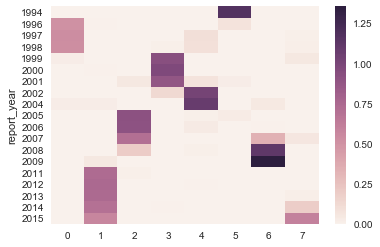

In [857]:
plot_topics(n_components=8)